In [1]:
import torch
import glob
import os
import pandas as pd
import numpy as np
import altair as alt
import model.loader as loader
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from model.module import THAN
from model.loader import MiniBatchSampler

In [2]:
MODEL_PREFIX = 'THAN-mem'
DATA = 'lol'
MODEL_SAVE_PATH = f'./saved_models/{MODEL_PREFIX}-{DATA}.pth'
NUM_NEIGHBORS = 10
N_DIM = 32
E_DIM = 16
T_DIM = 32
BATCH_SIZE = 200
NUM_LAYER = 1
NUM_HEADS = 4
DROPOUT = 0.1
GPU = -1

device = torch.device('cuda:{}'.format(GPU)) if GPU != -1 else 'cpu'

In [3]:
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def evaluate_score(labels, prob):
    pred_score = np.array((prob).cpu().detach().numpy())

    auc = roc_auc_score(labels, pred_score)
    ap = average_precision_score(labels, pred_score)
    return ap, auc

def eval_one_epoch(model: THAN, batch_sampler, data):
    val_ap, val_auc = [], []
    with torch.no_grad():
        model = model.eval()
        batch_sampler.reset()
        r_prob, r_lbls, r_src, r_dst, r_ts = [], [], [], [], []
        r_lab = []
        while True:
            batches, counts, classes = batch_sampler.get_batch_index()
            if counts is None or counts.sum()==0:
                break
            tiles = len(batches)
            l = int(counts.sum() * tiles)

            src_l_cut = np.empty(l, dtype=int)
            dst_l_cut = np.empty(l, dtype=int)
            ts_l_cut = np.empty(l, dtype=int)
            src_utype_l_cut = np.empty(l, dtype=int)
            dst_utype_l_cut = np.empty(l, dtype=int)
            etype_l = np.empty(l, dtype=int)
            lbls = np.empty(l)
            s_idx = 0
            for i, batch in enumerate(batches):
                e_idx = s_idx + int(counts[i] * tiles)
                src_l_cut[s_idx: e_idx] = np.repeat(data.src_l[batch], tiles)
                dst_l_cut[s_idx: e_idx] = np.repeat(data.dst_l[batch], tiles)
                ts_l_cut[s_idx: e_idx] = np.repeat(data.ts_l[batch], tiles)
                src_utype_l_cut[s_idx: e_idx] = np.repeat(data.u_type_l[batch],
                                                        tiles)
                dst_utype_l_cut[s_idx: e_idx] = np.repeat(data.v_type_l[batch],
                                                        tiles)
                etype_slice = np.tile(classes, len(batch))
                etype_l[s_idx: e_idx] = etype_slice
                lbls[s_idx: e_idx] = (etype_slice == classes[i]).astype(np.float64)
                s_idx = e_idx

            prob = model.link_contrast(src_l_cut, dst_l_cut, ts_l_cut,
                                       src_utype_l_cut, dst_utype_l_cut,
                                       etype_l, lbls, NUM_NEIGHBORS)
            prob = prob.reshape((len(prob) // tiles, tiles))
            prob = prob / prob.sum(1, keepdim=True)
            lbls = lbls.reshape((len(lbls) // tiles, tiles))
            ap, auc = evaluate_score(lbls, prob)
            prob = prob.reshape(len(prob) * tiles)
            lbls = lbls.reshape(len(lbls) * tiles)

            r_prob = np.concatenate([r_prob, prob])
            r_lbls = np.concatenate([r_lbls, etype_l])
            r_src = np.concatenate([r_src, src_l_cut])
            r_dst = np.concatenate([r_dst, dst_l_cut])
            r_ts = np.concatenate([r_ts, ts_l_cut])
            r_lab = np.concatenate([r_lab, lbls])
            val_ap.append(ap)
            val_auc.append(auc)
    print(np.mean(val_auc), np.mean(val_ap))
    return r_prob, r_lbls, r_src, r_dst, r_ts, r_lab

In [4]:
g, _, _, _, val, p_classes = loader.load_and_split_data_train_test_val(DATA, N_DIM, E_DIM)
val_ngh_finder = loader.get_neighbor_finder(g, g.max_idx, num_edge_type=g.num_e_type)
val_batch_sampler = MiniBatchSampler(val.e_type_l, BATCH_SIZE, 'test', p_classes)

model = THAN(val_ngh_finder, g.n_feat, g.e_feat, g.e_type_feat, g.num_n_type, g.num_e_type, T_DIM, num_layers=NUM_LAYER, n_head=NUM_HEADS, dropout=DROPOUT, device=device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [5]:
prob, lbls, src_l, dst_l, ts_l, lab = eval_one_epoch(model, val_batch_sampler, val)
preddict = {'prob': prob, 'lbl': lbls, 'src_id': src_l, 'dst_id': dst_l, 'ts': ts_l, 'lab': lab}
preds = pd.DataFrame(preddict)
preds['ts'] = preds['ts'] - 1

0.5423057727143166 0.545630778671455


In [7]:
'''NBA'''
if DATA == 'nba':
    matches = pd.read_csv('./data/raw/nba/games.csv').assign(ts = lambda _d: (pd.to_datetime(_d['game_date']).astype(int) / 10**9))
    team_dict = pd.read_csv('./data/processed/nba/teams_dict.csv')
    team_dict = team_dict.rename(columns={'Unnamed: 0': 'team_id', '0': 'id'})

    matches = pd.merge(matches, team_dict, how='left', left_on='team_id_home', right_on='team_id')
    matches = pd.merge(matches, team_dict, how='left', left_on='team_id_away', right_on='team_id')

    match_pred = pd.merge(matches, preds, left_on=['id_x', 'id_y', 'ts'], right_on=['src_id', 'dst_id', 'ts'])
    match_pred = match_pred.sort_values('prob', ascending=False).drop_duplicates('game_id')
    match_pred['label'] = match_pred['wl_home'].map({'W': 1, 'L': 0})

'''Soccer'''
if DATA == 'soccer':
    matches = pd.read_csv('./data/raw/soccer/matches.csv').assign(ts = lambda _d: (pd.to_datetime(_d['date']).astype(int) / 10**9)).drop(columns=['id'])

    team_dict = pd.read_csv('./data/processed/soccer/teams_dict.csv')
    team_dict = team_dict.rename(columns={'Unnamed: 0': 'team_id', '0': 'id'})

    matches = pd.merge(matches, team_dict, how='left', left_on='home_team_api_id', right_on='team_id')
    matches = pd.merge(matches, team_dict, how='left', left_on='away_team_api_id', right_on='team_id')

    match_pred = pd.merge(matches, preds, left_on=['id_x', 'id_y', 'ts'], right_on=['src_id', 'dst_id', 'ts'])
    match_pred = match_pred.sort_values('prob', ascending=False).drop_duplicates('match_api_id')

    match_pred['label'] = match_pred['home_team_goal'] - match_pred['away_team_goal']
    match_pred.loc[match_pred['label'] > 0, 'label'] = 1
    match_pred.loc[match_pred['label'] == 0, 'label'] = 2
    match_pred.loc[match_pred['label'] < 0, 'label'] = 0

'''LoL'''
if DATA == 'lol':
    all_files = glob.glob(os.path.join('./data/raw/lol', '*.csv'))
    df = (pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        .assign(ts = lambda _d: (pd.to_datetime(_d['date']).astype('int64') / 10**9).astype('int')))
    home = df.loc[df['side'] == 'Blue', ['teamid', 'gameid', 'result', 'ts', 'gamelength']].dropna().drop_duplicates()
    away = df.loc[df['side'] == 'Red', ['teamid', 'gameid']].dropna().drop_duplicates()

    matches = home.merge(away, how='inner', on='gameid')
    matches = matches.loc[matches['teamid_x'] != matches['teamid_y']]

    team_dict = pd.read_csv('./data/processed/lol/teams_dict.csv')
    team_dict = team_dict.rename(columns={'Unnamed: 0': 'team_id', '0': 'id'})

    matches = pd.merge(matches, team_dict, how='left', left_on='teamid_x', right_on='team_id')
    matches = pd.merge(matches, team_dict, how='left', left_on='teamid_y', right_on='team_id')

    match_pred = pd.merge(matches, preds, left_on=['id_x', 'id_y', 'ts'], right_on=['src_id', 'dst_id', 'ts'])
    match_pred = match_pred.sort_values('prob', ascending=False).drop_duplicates('gameid')

    match_pred['label'] = match_pred['result']

C:\Users\Ulysses\AppData\Local\Temp\ipykernel_3944\3715641573.py:35: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = (pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\Users\Ulysses\AppData\Local\Temp\ipykernel_3944\3715641573.py:35: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = (pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [9]:
match_pred['correct'] = (match_pred['label'] == match_pred['lbl']).astype(int)

,teamid_x,gameid,result,ts,gamelength,teamid_y,team_id_x,id_x,team_id_y,id_y,prob,lbl,src_id,dst_id,lab,label,correct
1429,oe:team:a3e5d7937cfb8a6d810b5d18d0b1fe7,NA1_4315088157,1,1653347845,1511,oe:team:f85f96a7979a43af6e1b26bd96df8a9,oe:team:a3e5d7937cfb8a6d810b5d18d0b1fe7,1120,oe:team:f85f96a7979a43af6e1b26bd96df8a9,1684,0.905081,1.0,1120.0,1684.0,1.0,1,1
15285,oe:team:ecaf2adae2ff7f9511c9f662f18ffe7,ESPORTSTMNT02_3140730,1,1674765652,2195,oe:team:108d8dd5293715c077fd7e33643028c,oe:team:ecaf2adae2ff7f9511c9f662f18ffe7,1602,oe:team:108d8dd5293715c077fd7e33643028c,96,0.888742,1.0,1602.0,96.0,1.0,1,1
24105,oe:team:9336ce46babf314b50e3a103506ae0a,ESPORTSTMNT03_3143394,1,1681769168,1612,oe:team:2ef1e4f46f806850b2fb250af865813,oe:team:9336ce46babf314b50e3a103506ae0a,1009,oe:team:2ef1e4f46f806850b2fb250af865813,311,0.878165,1.0,1009.0,311.0,1.0,1,1
16459,oe:team:4161958403ac6cd3d1c4c132cda8c79,ESPORTSTMNT01_3300803,0,1675624401,1921,oe:team:0520f3fedc9144bc9c62fadd5fd0568,oe:team:4161958403ac6cd3d1c4c132cda8c79,412,oe:team:0520f3fedc9144bc9c62fadd5fd0568,30,0.872707,1.0,412.0,30.0,0.0,0,0
25913,oe:team:bbd25c9b9a5044937d8800dfeb8922e,ESPORTSTMNT03_3168082,0,1686244118,1914,oe:team:17fa6b1358f7feeb5a68bbf5cd3d0d6,oe:team:bbd25c9b9a5044937d8800dfeb8922e,1274,oe:team:17fa6b1358f7feeb5a68bbf5cd3d0d6,159,0.868382,1.0,1274.0,159.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24220,oe:team:3d4a6fe0ca7bda9057ee1172eb5761c,10029-10029_game_2,0,1682077893,2290,oe:team:557e2d6abd8a8896014e4351756c305,oe:team:3d4a6fe0ca7bda9057ee1172eb5761c,386,oe:team:557e2d6abd8a8896014e4351756c305,557,0.500022,0.0,386.0,557.0,1.0,0,1
11740,oe:team:a8c6d9059474d8fa4c57a093e9e43ac,ESPORTSTMNT05_3060589,1,1662053819,1991,oe:team:5a5f8cc0161f43afe3461b293535517,oe:team:a8c6d9059474d8fa4c57a093e9e43ac,1149,oe:team:5a5f8cc0161f43afe3461b293535517,589,0.500015,0.0,1149.0,589.0,0.0,1,0
3560,oe:team:67140a291d66109643b99e9dff2cbc3,9022-9022_game_1,0,1655622960,1913,oe:team:7f60009d2aa9ce24f05deec2010a33f,oe:team:67140a291d66109643b99e9dff2cbc3,697,oe:team:7f60009d2aa9ce24f05deec2010a33f,873,0.500014,0.0,697.0,873.0,1.0,0,1
18278,oe:team:51eb4ab719043c7abdfca6fdddd1c5c,ESPORTSTMNT01_3318108,0,1676844223,1601,oe:team:8776b7033f1bc10634e50d90f861c1d,oe:team:51eb4ab719043c7abdfca6fdddd1c5c,532,oe:team:8776b7033f1bc10634e50d90f861c1d,924,0.500011,0.0,532.0,924.0,1.0,0,1


In [11]:
# Create csvs for visualization
OUT_DIR = './data/processed/' + DATA
match_pred.to_csv(f'{OUT_DIR}/match_pred.csv')

PermissionError: [Errno 13] Permission denied: './data/processed/lol/match_pred.csv'

In [ ]:
match_pred['bin'] = pd.qcut(match_pred.sort_values('ts')['ts'], 30)
binned = match_pred.groupby('bin')['correct'].agg(['sum', 'count'])
binned['accuracy'] = binned['sum'] / binned['count']
binned = binned.reset_index()
binned['bin'] = binned['bin'].astype(str)

/tmp/ipykernel_16206/4015973368.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = match_pred.groupby('bin')['correct'].agg(['sum', 'count'])


In [ ]:
alt.Chart(binned).mark_bar().encode(
    x='bin',
    y='accuracy',
).properties(title='Model Accuracy over Time')

alt.Chart(...)

[[4062 4250]
 [3551 6016]]


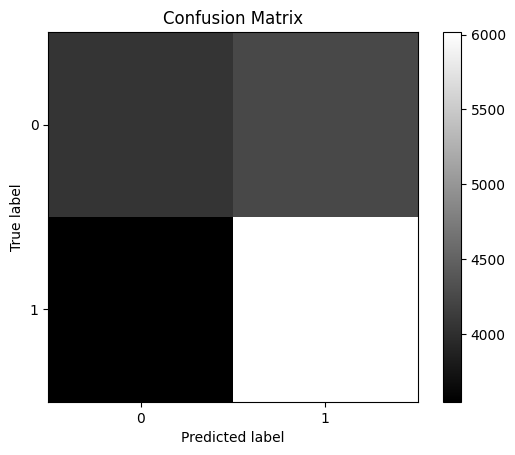

In [ ]:
confusion_mat = confusion_matrix(match_pred['label'], match_pred['lbl'])
print(confusion_mat)
plot_confusion_matrix(confusion_mat, len(p_classes))

In [ ]:
result_metrics = classification_report(match_pred['label'], match_pred['lbl'])
print(result_metrics)

              precision    recall  f1-score   support

           0       0.53      0.49      0.51      8312
           1       0.59      0.63      0.61      9567

    accuracy                           0.56     17879
   macro avg       0.56      0.56      0.56     17879
weighted avg       0.56      0.56      0.56     17879

